# 21cm Sensitivity Plots

## Load

In [74]:
user = 'gridgway'

In [5]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%matplotlib inline

In [7]:
%autoreload
import darkhistory.physics as phys

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
import darkhistory.spec.spectools as spectools
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import main


Bad key "legend.title_fontsize" on line 41 in
matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Structure Formation

In [8]:
struct_boost_einasto = phys.struct_boost_func('einasto_with_subs')

## $T_{21}$ input

Calculate upper bound for $T_m$ using 
$$
    T_\text{21}(z) \approx (1-\frac{T_R}{T_S})
$$
where the constant of proportionality is given by 
$$
    \sqrt{\frac{.15}{10}} ...
$$
and we have assumed $T_R(z) = T_\text{CMB}(z)$ 

Calculate the $T_{IGM}$ bound, $T_\text{bnd}$ provided a measurement of $T_{21}$.  Assume $x_e \approx 2\times 10^{-4}$

In [68]:
T_21 = -50 #in mK
end_rs = 1 + 17.2
num = np.sqrt(.15/10/phys.omega_m*end_rs)*(phys.omega_baryon*phys.h/.02)*(1-2e-4)*23
one_minus_ratio = T_21 / num
Tm_bnd = phys.TCMB(end_rs)/(1-one_minus_ratio)/phys.kB
#HACK
Tm_bnd /= (1+.01)
print("T_m < ", Tm_bnd, "K")

T_m <  20.40198184264633 K


# Scan through $m_\chi$ and $\tau$ or $\sigma v$

## swave annihilation

Specify type of injection (swave or decay) and products ($e^+e^-$ or $\gamma\gamma$)

In [116]:
inj_particle = 'photon'
inj_str = inj_particle[:4]
inj_type = 'swave'

if inj_type == 'swave':
    struct_boost = struct_boost_einasto
    struct_func = struct_boost
else:
    def struct_boost(rs):
        return 1
    struct_func = None
    
if inj_particle == 'photon':
    mass = 0
    coarsen_factor=4
else:
    mass = phys.me
    coarsen_factor=12

rs_init = 3000

Given a dark matter mass and $\tau$ or $\sigma v$, calculate $T(z=17.2)$.

In [117]:
def get_T(mDM, log10_p, backreaction):
    if inj_type == 'decay':
        Einj = mDM/2-mass
        Ecom=mDM
    if inj_type == 'swave':
        Einj = mDM - mass
        Ecom = 2*mDM
        
    if inj_particle == 'photon':
        primary = 'phot_delta'
    else:
        primary = 'elec_delta'

    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, tau=10**log10_p, sigmav=10**log10_p*mDM/1e9)*struct_boost(rs)

    a = main.evolve(
            primary=primary,
            rate_func_N=rate_func_N, rate_func_eng=rate_func_eng,
            DM_process=inj_type, mDM=mDM, sigmav=10**log10_p*mDM/1e9, lifetime=10**log10_p,
            start_rs = 3000, end_rs=end_rs,
            coarsen_factor=coarsen_factor, backreaction=backreaction,
            struct_boost=struct_boost
    )
    return a['Tm'][-1]/phys.kB

Set up a $(m_\chi, \tau \text{ or } \sigma v)$ grid over which to scan

In [118]:
%autoreload
step = .25
if inj_particle == 'photon':
    mbnds = [4,12.5]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [23,28.25 + step] #tau
        param_guess = 27
    else:
        parambnds = [-28,-25 + step] # sigma v / mDM
        param_guess = -26.5
else:
    mbnds = [6.01,12.51]
    log10mDM_arr = np.arange(mbnds[0], mbnds[1], step)

    if inj_type == 'decay':
        parambnds = [24,28.25 + step]
        param_guess = 27
    else:    
        parambnds = [-30.5,-24.5 + step]
        param_guess = -26
    
log10_param = np.arange(parambnds[0], parambnds[1], step)

Conduct the scan without back-reaction.

Loop a grid of $E_\text{inj}$ values, $E^i_\text{inj}$.  
For the first grid value, $E^0_\text{inj}$, provide a guess (`param_guess`) for the $\tau$ or $\langle \sigma v \rangle$ that leads to $T_m(z=17.2)$ attaining its bound.  If the guess led to $T_m(z=17.2) > T_\text{bnd}$, increase $\tau$ or decrease $\langle \sigma v \rangle$.  If $T_m(z=17.2) < T_\text{bnd}$, decrease $\tau$ or increase $\langle \sigma v \rangle$.  Repeat this process until $T_m(z=17.2)$ crosses the bound once.

For the next injection energies set `param_guess` to the value that $\tau$ or $\langle \sigma v \rangle$ arrived at in the previous step and repeat.

In [119]:
%autoreload
download_T = True
if download_T:
    T_IGM_17_std = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Gregs_Checks/T_IGM_17_'+
             inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','rb'))
else:
    T_IGM_17_std = np.zeros((log10mDM_arr.size, log10_param.size))

    for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
        print('log10(mDM): ', log10mDM)
        mDM = 10**log10mDM
        j=len(log10_param[log10_param < param_guess])
        above=False
        below=False

        while((not below) or (not above)):
            log10_p = log10_param[j]
            print('log10(param): ', log10_p)

            T_std = get_T(mDM, log10_p, backreaction=False)
            T_IGM_17_std[i,j] = T_std
            print('T_0 [K]: ', T_std)

            if T_std > Tm_bnd:
                above = True
                print("T_std Above Threshold")
                if inj_type == 'swave':
                    j = j-1
                else:
                    j = j+1
            else:
                below = True
                print("T_std Below Threshold")
                if inj_type == 'swave':
                    j = j+1
                else:
                    j = j-1

            param_guess = log10_p        

    pickle.dump(
        T_IGM_17_std, 
        open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Gregs_Checks/T_IGM_17_'+
             inj_str+'_'+inj_type+'_std_coarsen'+str(coarsen_factor)+'.dat','wb')
    )

Linearly interpolate over the parameter values to find the $\tau$ or $\sigma$ that saturates the $T_m(z=17.2)$ bound.

In [120]:
def find_param(Tlist):
    if inj_type == 'swave':
        above = np.nonzero(Tlist > Tm_bnd)[0][-1]
        below = above-1
    else:
        above = np.nonzero(Tlist > Tm_bnd)[0][0]
        below = above+1
    Ts = [Tlist[below], Tlist[above]]
    ps = [log10_param[below], log10_param[above]]
    return (np.diff(ps)/np.diff(Ts)*(Tm_bnd-Ts[0]) + ps[0])[0]

thresh_params_std = np.array(
    [find_param(row) for row in T_IGM_17_std]
)

Conduct the scan with back-reaction

In [121]:
%autoreload
download_T = True
if download_T:
    T_IGM_17_BR = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Gregs_Checks/T_IGM_17_'+
             inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','rb'))
else:
    T_IGM_17_BR = np.zeros((log10mDM_arr.size, log10_param.size))
    param_guess = thresh_params_std[0]

    for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
        print('log10(mDM): ', log10mDM)
        mDM = 10**log10mDM
        j=len(log10_param[log10_param < param_guess])
        above=False
        below=False

        while((not below) or (not above)):
            log10_p = log10_param[j]
            print('log10(param): ', log10_p)

            T_BR = get_T(mDM, log10_p, backreaction=True)
            T_IGM_17_BR[i,j] = T_BR
            print('T_0 [K]: ', T_BR)

            if T_BR > Tm_bnd:
                above = True
                print("T_BR Above Threshold")
                if inj_type == 'swave':
                    j = j-1
                else:
                    j = j+1
            else:
                below = True
                print("T_BR Below Threshold")
                if inj_type == 'swave':
                    j = j+1
                else:
                    j = j-1
            param_guess = log10_p


    pickle.dump(
        T_IGM_17_BR, 
        open('/Users/gridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/T_IGM_17_'+
             inj_str+'_'+inj_type+'_BR_coarsen'+str(coarsen_factor)+'.dat','wb')
    )

Find the $\tau$ or $\sigma$ that saturates the $T_m(z=17.2)$ bound when including backreaction.

In [122]:
thresh_params_BR = np.array(
    [find_param(row) for row in T_IGM_17_BR]
)

### Plots

Make an interpolation function for the points $(m_\text{DM}, \tau_\text{min})$ or $(m_\text{DM}, \sigma_\text{max})$ with and without backreaction.

In [123]:
thresh_params_BR = np.array([find_param(row) for row in T_IGM_17_BR])

std_interp = interp1d(log10mDM_arr, thresh_params_std, kind='quadratic')
BR_interp = interp1d(log10mDM_arr, thresh_params_BR, kind='quadratic')

log10mDM_arr_fine = np.arange(log10mDM_arr[0], log10mDM_arr[-1], .01)

/Users/gridgway/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


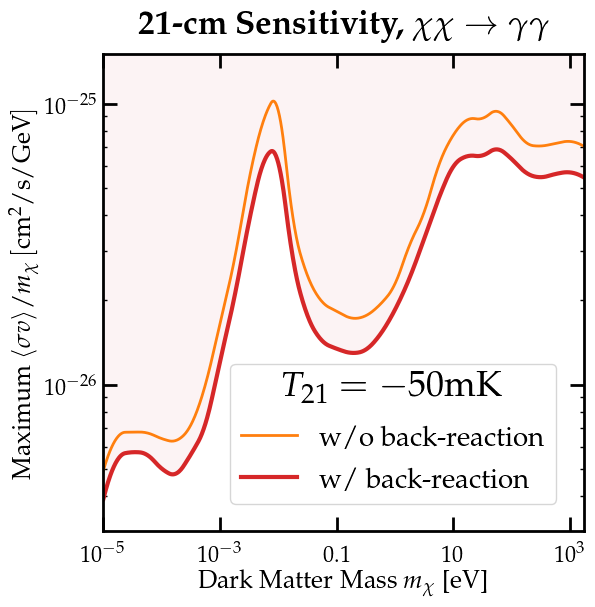

In [124]:
plt.figure()
ax = plt.gca()
ax.loglog()

xmin = 10**log10mDM_arr_fine[0]/1e9
xmax = 10**log10mDM_arr_fine[-1]/1e9

if inj_particle=='electron':
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \chi \to e^+ e^-$')
        ymin = 5e-29
        ymax = 1e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to e^+ e^-$')
        ymin = 5e24
        ymax = 4e27
else:
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi\chi \to \gamma\gamma$')
        ymin = 3e-27
        ymax = 1.5e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma\gamma$')
        ymin = 2e23
        ymax = 4e26
    
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
if inj_type == 'swave':
    plt.ylabel(r'Maximum $\langle \sigma v \rangle / m_\chi \, [\mathrm{ cm^2 / s / GeV}]$')
else:
    plt.ylabel(r'Minimum Lifetime $\tau \, [\mathrm{s}]$')
    
plt.axis([xmin, xmax, ymin, ymax])

plt_std, = plt.plot(10**log10mDM_arr_fine/1e9, 10**std_interp(log10mDM_arr_fine), 
        linewidth=2, label='w/o back-reaction', color='C1')
plt_BR, = plt.plot(10**log10mDM_arr_fine/1e9, 10**BR_interp(log10mDM_arr_fine), 
         linewidth=3, label='w/ back-reaction', color='C3')

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**BR_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='C3',
    alpha=.05
)

leg = plt.legend(handles=[plt_std, plt_BR],
                 fontsize=20,
          title='$T_{21} = -50$mK')
plt.setp(leg.get_title(), fontsize=26)
plt.show()

# plt.savefig('/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/'+
#             'DarkHistory_21cm_Sensitivity_'+inj_type+'_'+inj_str+'.png')